# Defasagem Espacial Sul  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/defasagem_espacial_sul.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
dados_br = cod_dados.merge(seguro, how='left')

In [19]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

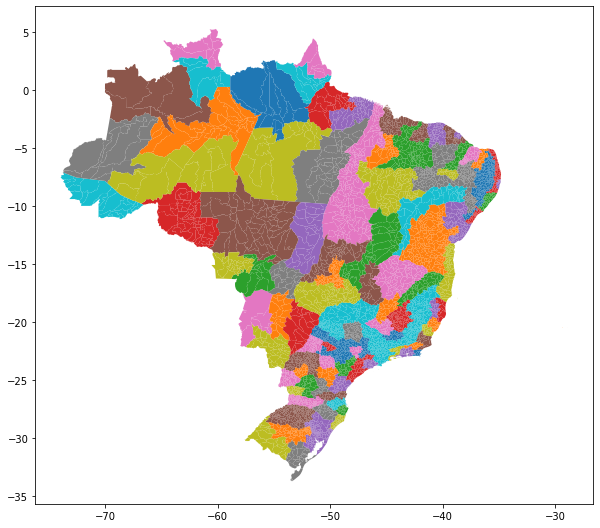

In [20]:
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Sul

In [21]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

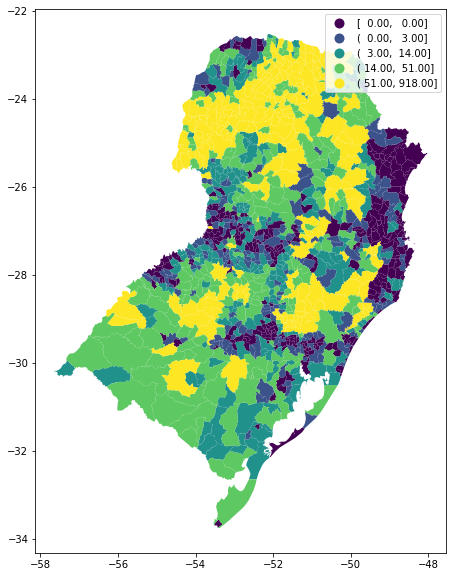

In [22]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd'

## Defasagem espacial - Sul

In [23]:
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [24]:
dados_sul.columns

Index(['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0', 'rm'] # , 'geometry'
dados_lag = dados_sul.drop(retirar, axis = 1)

In [26]:
dados_lag.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
for variavel in dados_lag.drop(['nome_mun', 'geometry'], axis = 1).columns:
    dados_lag[variavel+'_lag'] = weights.spatial_lag.lag_spatial(w, dados_lag[variavel])

In [28]:
dados_lag = dados_lag.set_index('nome_mun')

In [29]:
dados_lag.head()

,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
nome_mun,,,,,,,,,,,,,,,,,
abatia,"POLYGON ((-50.22465 -23.22603, -50.22482 -23.2...",40.0,3543216.22,304971.61,134087.83,587718.37,21649.66,1141.40,26.0,122.000000,1.832898e+07,1.388129e+06,607043.117500,2.597552e+06,51319.365,1944.255000,57.5
adrianopolis,"POLYGON ((-48.99969 -24.63712, -49.00943 -24.6...",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.333333,1.978600e+06,3.778476e+04,14003.636667,0.000000e+00,0.000,29.666667,0.0
agudos_do_sul,"POLYGON ((-49.30433 -25.94769, -49.29320 -25.9...",2.0,446126.98,51446.03,23150.71,20487.60,924.00,0.23,1.0,3.000000,1.672307e+05,9.925758e+03,4227.454000,0.000000e+00,0.000,106.800000,0.0
almirante_tamandare,"POLYGON ((-49.28261 -25.22827, -49.25086 -25.2...",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000,0.000000,0.0
altamira_do_parana,"POLYGON ((-52.81511 -24.71726, -52.79698 -24.7...",4.0,892341.25,53858.49,24236.32,0.00,0.00,233.00,0.0,69.600000,9.287946e+06,6.862113e+05,297705.336000,5.414249e+05,18662.156,1152.424000,13.8


## Análise de agrupamento - Defasagem espacial - Sul

In [30]:
# subselecionar variáveis
X = scale(dados_lag.drop('geometry', axis=1))
# mudar o tipo dos dados
XX = np.asarray(X, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [31]:
Z = linkage(X, method='ward')

In [32]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [33]:
import sys
print(sys.getrecursionlimit())
# sys.setrecursionlimit(2000)

3000


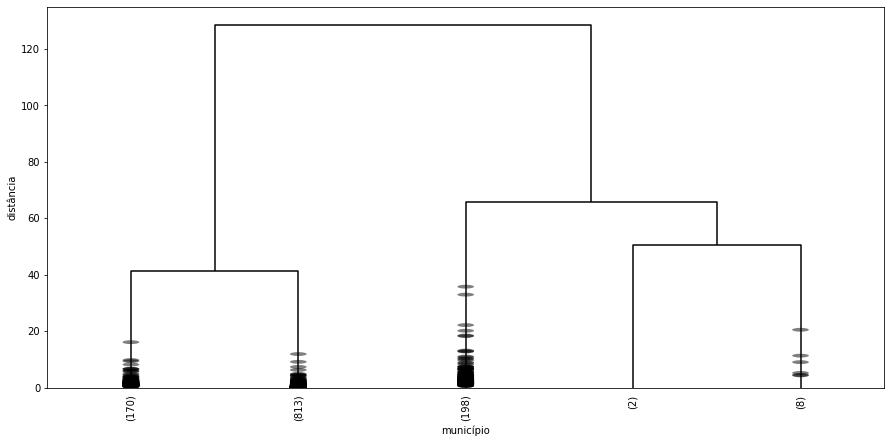

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [35]:
Z = linkage(X, method='ward')

In [36]:
# definir a distância de corte baseando no dendrograma
max_d = 40
grupos = cut_tree(Z, height=max_d)

### Métricas

In [37]:
dados_metrics = dados_lag.drop('geometry', axis=1)

In [38]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

571.13 1.02 0.47


In [39]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_lag['grupo'] = grupos
# moran_matrix.head(2)

In [40]:
# contagem de observações em cada grupo
dados_lag.grupo.value_counts()

1    813
0    198
2    170
4      8
3      2
Name: grupo, dtype: int64

In [41]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,127.196970,1.696727e+07,1.378515e+06,6.030577e+05,1.739096e+06,32077.715303,1839.785657,44.939394,139.689362,1.879154e+07,1.595002e+06,7.006230e+05,1.963018e+06,32633.767258,1841.680031,51.104091
1,6.790898,1.058895e+06,6.646350e+04,2.808253e+04,3.406904e+04,1418.760615,155.056224,0.917589,13.926990,2.344460e+06,1.594826e+05,6.788125e+04,8.310572e+04,2670.428650,242.002541,2.265741
2,52.705882,9.985248e+06,6.993720e+05,2.983715e+05,4.075765e+05,11315.620529,835.585412,10.117647,49.559082,9.997131e+06,7.549731e+05,3.203554e+05,4.378757e+05,10848.780046,799.735645,9.772660
3,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714
4,492.125000,4.598523e+07,3.187202e+06,1.434240e+06,1.487948e+07,49783.237500,1475.403750,316.250000,413.083333,3.855622e+07,2.779164e+06,1.250298e+06,1.050517e+07,34973.321042,1558.288594,225.781250


In [42]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,100.5,1.195096e+07,1.008214e+06,442757.315,1.173200e+06,30873.025,1789.860,31.5,128.312500,1.689357e+07,1.307447e+06,5.785497e+05,1.669785e+06,34280.416250,1922.516667,46.904762
1,2.0,1.764000e+05,1.214400e+04,5312.500,0.000000e+00,0.000,74.000,0.0,7.200000,1.139553e+06,7.263996e+04,2.929870e+04,2.466667e+04,1173.500000,167.562500,0.714286
2,42.0,8.607585e+06,6.279667e+05,263586.075,1.603515e+05,5898.045,783.695,5.0,44.666667,8.912151e+06,6.125751e+05,2.644939e+05,3.325097e+05,9427.875000,760.365000,7.000000
3,487.0,1.557418e+08,2.156674e+07,9364997.510,2.660479e+06,12995.410,2057.350,57.0,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714
4,441.0,4.611380e+07,3.028326e+06,1362745.360,1.295144e+07,38748.630,1545.810,259.5,420.500000,3.863781e+07,2.558148e+06,1.151166e+06,9.461256e+06,35207.352917,1574.305000,195.208333


### As observações de cada grupo


In [43]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [44]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

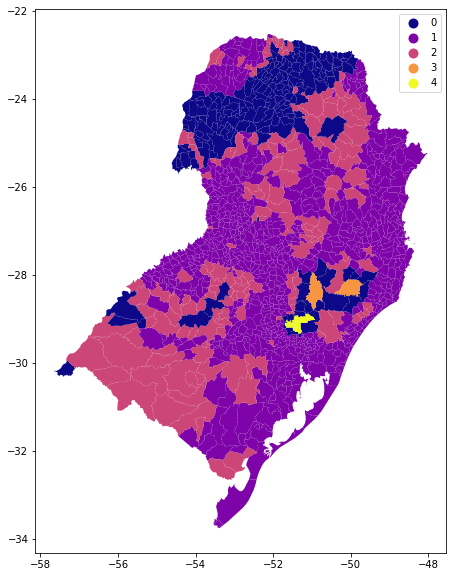

In [45]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - Defasagem espacial


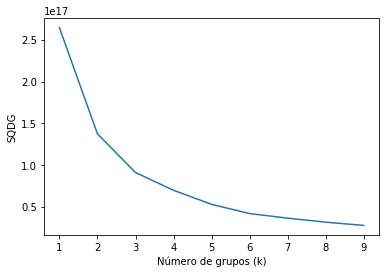

In [46]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_lag.drop('geometry', axis=1))
    dados_lag['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [47]:
k = 4

In [48]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [49]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

669.2 0.88 0.65


In [50]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_lag['grupo'] = kmeans.labels_

In [51]:
# contagens
dados_lag.grupo.value_counts()

0    963
1    211
2     15
3      2
Name: grupo, dtype: int64

In [52]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [53]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,13.657321,2.343866e+06,1.555959e+05,6.605546e+04,8.196862e+04,2666.824341,250.017124,2.179647,19.089969,3.407929e+06,2.400949e+05,1.021361e+05,1.362073e+05,3837.811078,323.818306,3.392125,5.959502
1,113.663507,1.578684e+07,1.275106e+06,5.582494e+05,1.486072e+06,30703.870427,1770.890379,38.075829,130.990818,1.781264e+07,1.487283e+06,6.524034e+05,1.782329e+06,31056.873782,1761.825155,46.571474,3.876777
2,431.200000,4.650714e+07,3.499023e+06,1.535438e+06,1.119107e+07,52006.193333,1984.444000,250.733333,312.542963,3.962854e+07,3.401357e+06,1.490626e+06,7.165580e+06,33854.076654,1749.329607,155.670820,3.066667
3,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714,3.000000


In [54]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,3.0,3.580900e+05,26221.27,10838.10,0.00,0.00,111.00,0.0,10.125000,1.645065e+06,1.051825e+05,4.367939e+04,4.149277e+04,1770.800000,227.660000,1.000000,8
1,91.0,1.159572e+07,972694.17,427823.08,1053314.25,29922.00,1714.25,29.0,118.833333,1.623937e+07,1.276085e+06,5.612816e+05,1.541840e+06,32859.150000,1849.860000,42.750000,5
2,390.0,4.335349e+07,3012188.96,1345018.98,8619055.17,46396.00,1777.36,242.0,342.000000,3.848018e+07,2.441558e+06,1.098701e+06,6.414210e+06,34502.014444,1868.485000,152.166667,4
3,487.0,1.557418e+08,21566742.09,9364997.51,2660478.72,12995.41,2057.35,57.0,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714,3


In [55]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [56]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

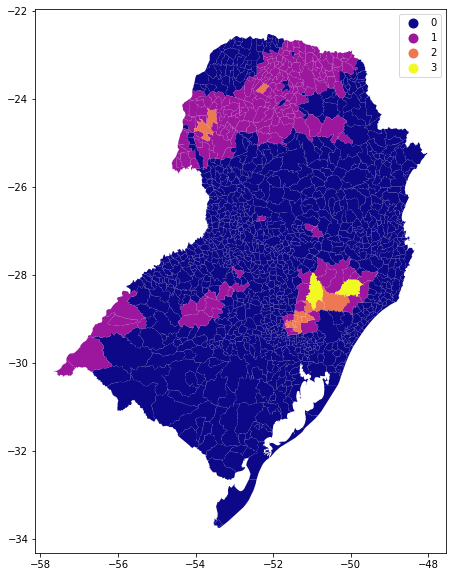

In [57]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering

In [58]:
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [63]:
model = AgglomerativeClustering(distance_threshold=40, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<1191x1191 sparse matrix of type '<class 'numpy.float64'>'
	with 5942 stored elements in Compressed Sparse Row format>,
                        distance_threshold=40, linkage='ward', memory=None,
                        n_clusters=None)

In [64]:
dados_lag['grupo'] = model.labels_

In [65]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

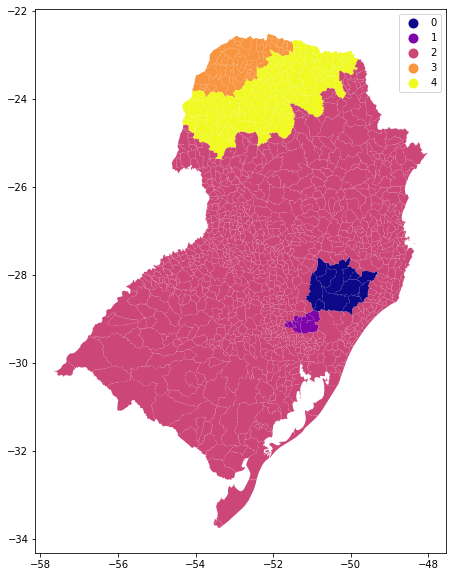

In [66]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'